In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ffn
import bt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

## Create fake data

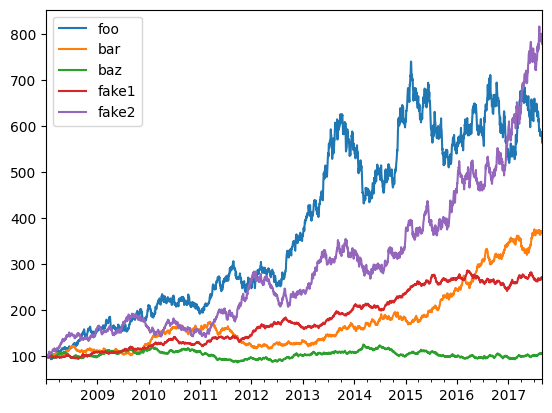

In [2]:
rf = 0.04
np.random.seed(1)
mus = np.random.normal(loc=0.05,scale=0.02,size=5) + rf
sigmas = (mus - rf)/0.3 + np.random.normal(loc=0.,scale=0.01,size=5)

num_years = 10
num_months_per_year = 12
num_days_per_month = 21
num_days_per_year = num_months_per_year*num_days_per_month

rdf = pd.DataFrame(
    index = pd.date_range(
        start="2008-01-02",
        periods=num_years*num_months_per_year*num_days_per_month,
        freq="B"
    ),
    columns=['foo','bar','baz','fake1','fake2']
)

for i,mu in enumerate(mus):
    sigma = sigmas[i]
    rdf.iloc[:,i] = np.random.normal(
        loc=mu/num_days_per_year,
        scale=sigma/np.sqrt(num_days_per_year),
        size=rdf.shape[0]
    )
pdf = np.cumprod(1+rdf)*100
pdf.iloc[0,:] = 100

pdf.plot();

In [3]:
strategy_names = np.array(
    [
        'Equal Weight',
        'Inv Vol'
    ]
)

runMonthlyAlgo = bt.algos.RunMonthly(
    run_on_first_date=True,
    run_on_end_of_period=True
)
selectAllAlgo = bt.algos.SelectAll()
rebalanceAlgo = bt.algos.Rebalance()

strats = []
tests = []

for i,s in enumerate(strategy_names):
    if s == "Equal Weight":
        wAlgo = bt.algos.WeighEqually()
    elif s == "Inv Vol":
        wAlgo = bt.algos.WeighInvVol()

    strat = bt.Strategy(
        str(s),
        [
            runMonthlyAlgo,
            selectAllAlgo,
            wAlgo,
            rebalanceAlgo
        ]
    )
    strats.append(strat)

    t = bt.Backtest(
        strat,
        pdf,
        integer_positions = False,
        progress_bar=False
    )
    tests.append(t)

In [6]:
strats

[<Strategy Equal Weight>, <Strategy Inv Vol>]

In [7]:
tests

In [4]:
combined_strategy = bt.Strategy(
    'Combined',
    algos = [
        runMonthlyAlgo,
        selectAllAlgo,
        bt.algos.WeighEqually(),
        rebalanceAlgo
    ],
    children = [x.strategy for x in tests]
)

combined_test = bt.Backtest(
    combined_strategy,
    pdf,
    integer_positions = False,
    progress_bar = False
)

res = bt.run(combined_test)

<Axes: >

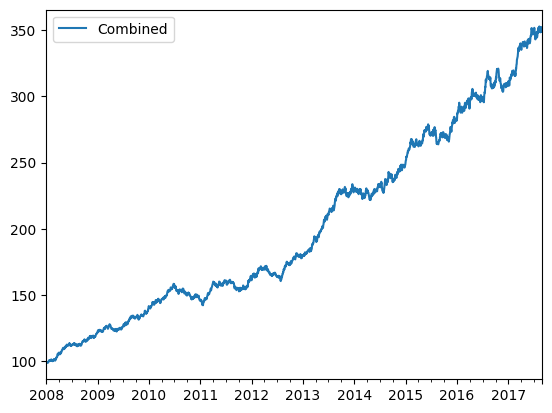

In [5]:
res.prices.plot()

<Axes: >

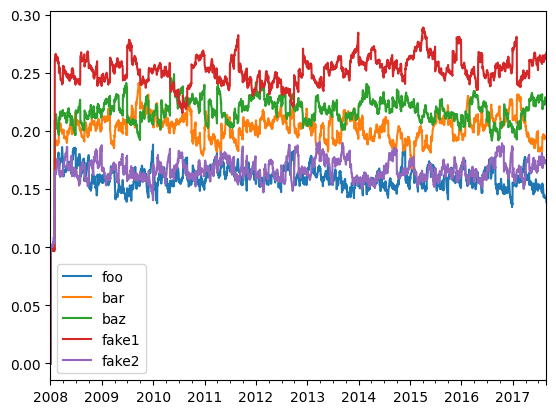

In [8]:
res.get_security_weights().plot()

In order to get the weights of each strategy, you can run each strategy, get the prices for each strategy, combine them into one price dataframe, run the combined strategy on the new data set.

In [9]:
strategy_names = np.array(
    [
        'Equal Weight',
        'Inv Vol'
    ]
)

runMonthlyAlgo = bt.algos.RunMonthly(
    run_on_first_date=True,
    run_on_end_of_period=True
)
selectAllAlgo = bt.algos.SelectAll()
rebalanceAlgo = bt.algos.Rebalance()

strats = []
tests = []
results = []

for i,s in enumerate(strategy_names):
    if s == "Equal Weight":
        wAlgo = bt.algos.WeighEqually()
    elif s == "Inv Vol":
        wAlgo = bt.algos.WeighInvVol()

    strat = bt.Strategy(
        s,
        [
            runMonthlyAlgo,
            selectAllAlgo,
            wAlgo,
            rebalanceAlgo
        ]
    )
    strats.append(strat)

    t = bt.Backtest(
        strat,
        pdf,
        integer_positions = False,
        progress_bar=False
    )
    tests.append(t)

    res = bt.run(t)
    results.append(res)

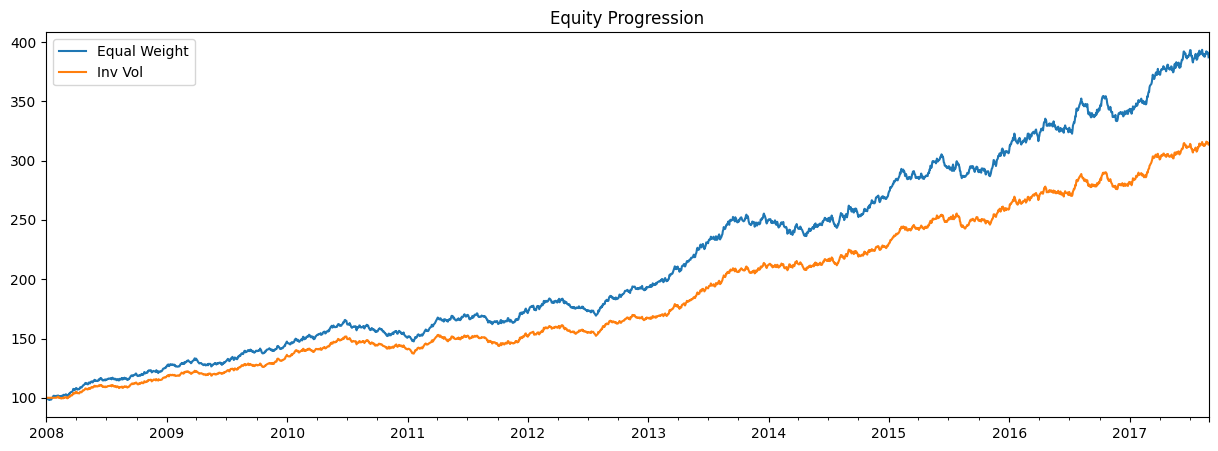

In [10]:
fig, ax = plt.subplots(nrows=1,ncols=1)
for i,r in enumerate(results):
    r.plot(ax=ax)

In [11]:
merged_prices_df = bt.merge(results[0].prices,results[1].prices)

combined_strategy = bt.Strategy(
    'Combined',
    algos = [
        runMonthlyAlgo,
        selectAllAlgo,
        bt.algos.WeighEqually(),
        rebalanceAlgo
    ]
)

combined_test = bt.Backtest(
    combined_strategy,
    merged_prices_df,
    integer_positions = False,
    progress_bar = False
)

res = bt.run(combined_test)

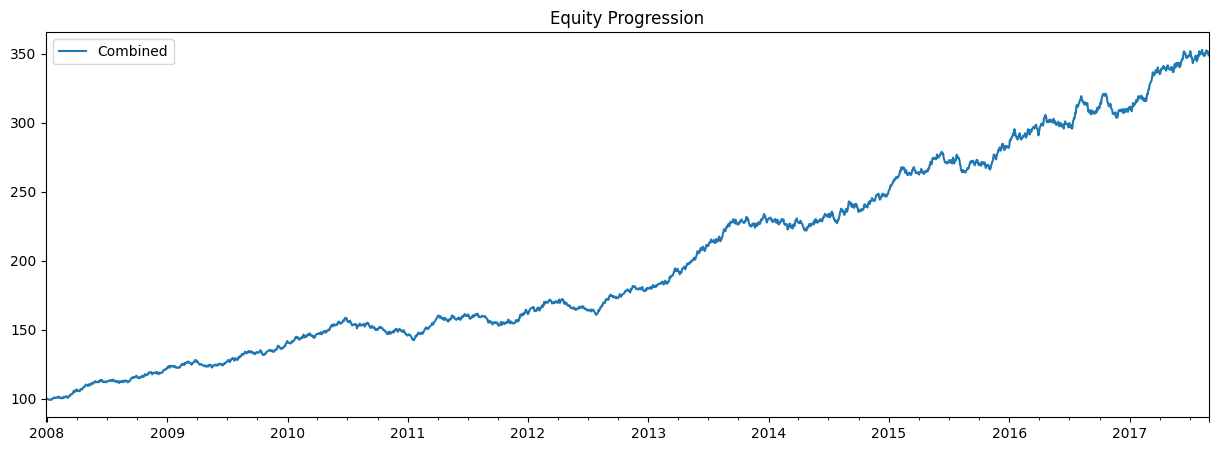

In [12]:
res.plot();

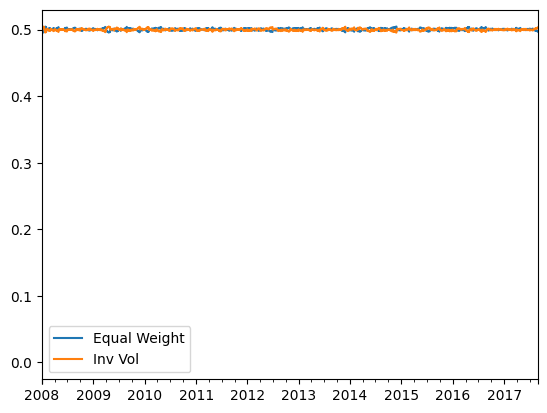

In [13]:
res.get_security_weights().plot();